In [8]:
df.daysabs.describe()

count    314.000000
mean       5.955414
std        7.036958
min        0.000000
25%        1.000000
50%        4.000000
75%        8.000000
max       35.000000
Name: daysabs, dtype: float64

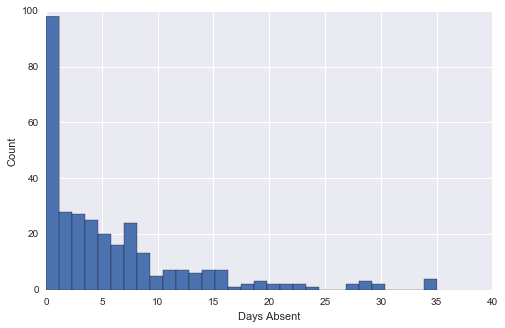

In [9]:
fig, ax = plt.subplots(figsize=(8, 5));
df.daysabs.hist(bins=30, ax=ax);
ax.set_xlabel('Days Absent');
ax.set_ylabel('Count');

In [10]:
df.groupby('prog')['daysabs'].describe()

prog       
1     count     40.000000
      mean      10.650000
      std        8.201157
      min        3.000000
      25%        4.750000
      50%        8.000000
      75%       15.000000
      max       34.000000
2     count    167.000000
      mean       6.934132
      std        7.446304
      min        0.000000
      25%        2.000000
      50%        5.000000
      75%        9.500000
      max       35.000000
3     count    107.000000
      mean       2.672897
      std        3.733519
      min        0.000000
      25%        0.000000
      50%        1.000000
      75%        4.000000
      max       19.000000
Name: daysabs, dtype: float64

In [2]:
import sys, os
sys.path.insert(0, '/Users/jonathanfriedman/pymc3')

import numpy as np
import pandas as pd
import pymc3 as pm
import re
import patsy as pt
from scipy import optimize
import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

In [121]:
q = 1000
intercept = 2
group_coefs = np.array([-0.1, -0.4, -1.2])
score_coef = -0.005
group = np.random.randint(0, 3, q)
score = np.random.randint(0, 101, q)

days_absent = np.random.negative_binomial(intercept + score_coef * score + group_coefs[group], 0.1) 
df = pd.DataFrame({'score': score, 'group': group, 'g0': group == 0, 
                   'g1': group == 1, 'g2': group == 2, 'days_absent': days_absent}, dtype=float)

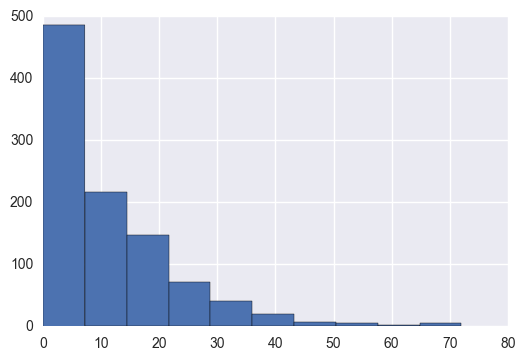

In [122]:
df.days_absent.hist();

In [115]:
# df = pd.read_csv('http://www.ats.ucla.edu/stat/mplus/dae/nb_data.dat', header=None, index_col=0,
#                  names='id gender math daysabs prog p1 p2 p3'.split())
fml = 'days_absent ~ score + g1 + g2'

In [123]:
vars_summary = df.describe().iloc[1:]
means = vars_summary.ix['mean']
vars_summary

,days_absent,g0,g1,g2,group,score
mean,11.088000,0.312000,0.347000,0.341000,1.029000,50.051000
std,11.361749,0.463542,0.476254,0.474283,0.807968,29.627727
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,0.000000,0.000000,23.000000
50%,8.000000,0.000000,0.000000,0.000000,1.000000,51.000000
75%,16.250000,1.000000,1.000000,1.000000,2.000000,77.000000
max,72.000000,1.000000,1.000000,1.000000,2.000000,100.000000


In [103]:
with pm.Model() as model:
    pm.glm.glm(formula=fml, data=df, family=pm.glm.families.NegativeBinomial())
    start = pm.find_MAP(fmin=optimize.fmin_powell)
    C = pm.approx_hessian(start)
    trace = pm.sample(4000, step=pm.NUTS(scaling=C))

Optimization terminated successfully.
         Current function value: 3340.737856
         Iterations: 10
         Function evaluations: 772


100%|██████████| 4000/4000 [00:40<00:00, 98.03it/s] 


In [111]:
def plot_traces_pymc(trcs, varnames=None):
    ''' Convenience fn: plot traces with overlaid means and values '''

    nrows = len(trcs.varnames)
    if varnames is not None:
        nrows = len(varnames)

    ax = pm.traceplot(trcs, varnames=varnames, figsize=(12,nrows*1.4),
                      lines={k: v['mean'] for k, v in
                             pm.df_summary(trcs,varnames=varnames).iterrows()})

    for i, mn in enumerate(pm.df_summary(trcs, varnames=varnames)['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data',
                         xytext=(5,10), textcoords='offset points', rotation=90,
                         va='bottom', fontsize='large', color='#AA0022')
        
def strip_derived_rvs(rvs):
    '''Convenience fn: remove PyMC3-generated RVs from a list'''
    ret_rvs = []
    for rv in rvs:
        if not (re.search('_log',rv.name) or re.search('_interval',rv.name)):
            ret_rvs.append(rv)
    return ret_rvs

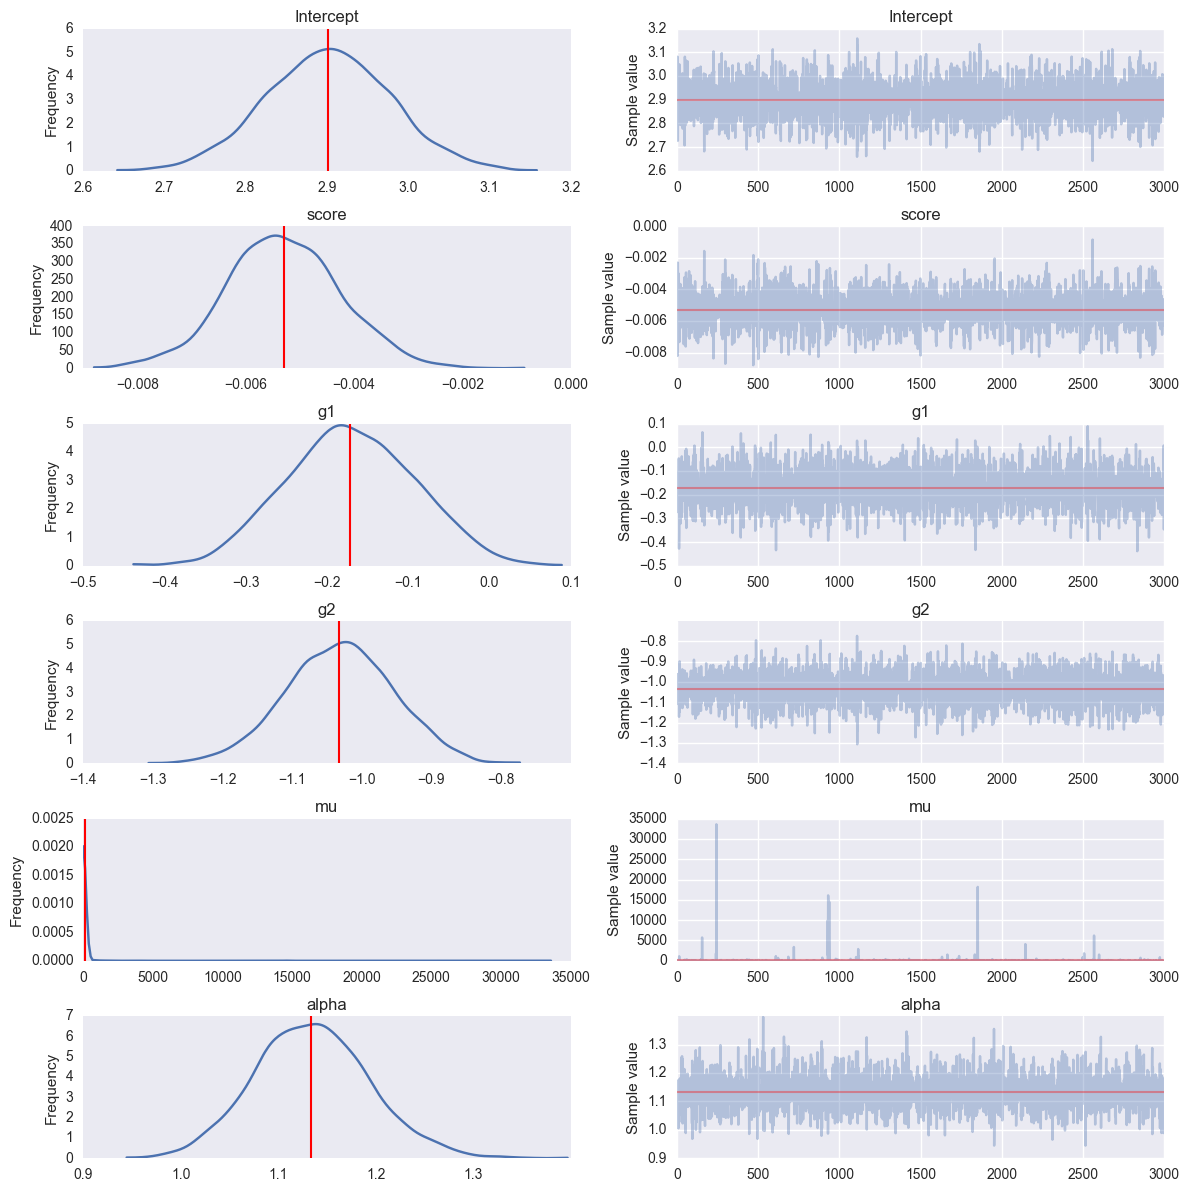

In [113]:
rvs = [rv.name for rv in strip_derived_rvs(model.unobserved_RVs)]
pm.traceplot(trace[1000:], lines={v: trace[1000:][v].mean() for v in rvs});

In [114]:
results_summary = pm.df_summary(trace[1000:], varnames=rvs)[['mean','hpd_2.5','hpd_97.5']]
coefs = results_summary['mean']
results_summary

,mean,hpd_2.5,hpd_97.5
Intercept,2.900823,2.755686,3.054672
score,-0.005296,-0.007405,-0.003226
g1,-0.171342,-0.313324,-0.014206
g2,-1.032295,-1.181781,-0.886235
mu,92.149367,0.005587,126.139341
alpha,1.134001,1.019372,1.250096


In [128]:
base = means.math * coefs.math + coefs.Intercept

print(np.exp(base))
print(np.exp(base + coefs.p2))
print(np.exp(base + coefs.p3))

10.3917633493
6.61465829263
2.84359792159


In [ ]:
def predict(intercept, math, p1, p2, data):
    intercept + 